In [1]:
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os, sys

sys.path.append('../src')

from imp import load_source
from models import *
from utils import *

try:
    tf.enable_eager_execution()
except:
    pass

tf.executing_eagerly()

Using TensorFlow backend.



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Clustering analysis on 10k PBMC data

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters
# parameters = {
#     'latent_dim': 100,
#     'layers_enc_dim': [1000, 500, 400, 300, 200],
#     'layers_dec_dim': [200, 300, 400, 500, 1000],
#     'layers_dis_dim': [1000, 500, 400, 300, 200],
#     'batch_size': 1000,
#     'epochs': 20
# }

parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC10k/graphs/autoencoder.png)

### Train the model

In [11]:
# Create the input dataset
MODE = 'TFRecord'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

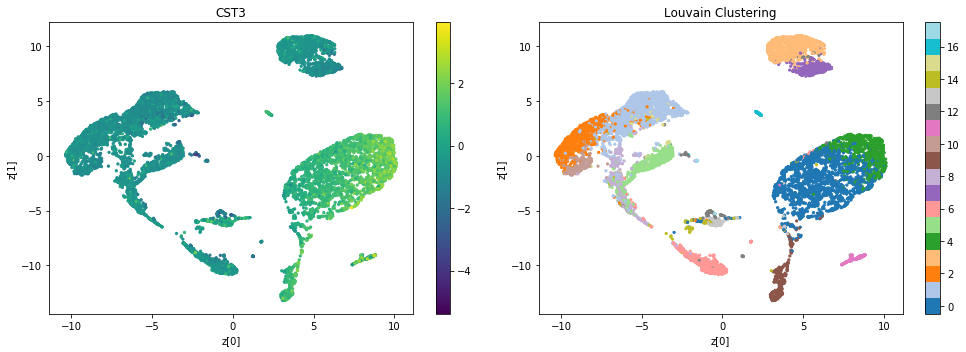

In [14]:
GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/AAE1/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [16]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [40:12<00:00, 13.71s/it]


In [17]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

121
132
121


In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 16


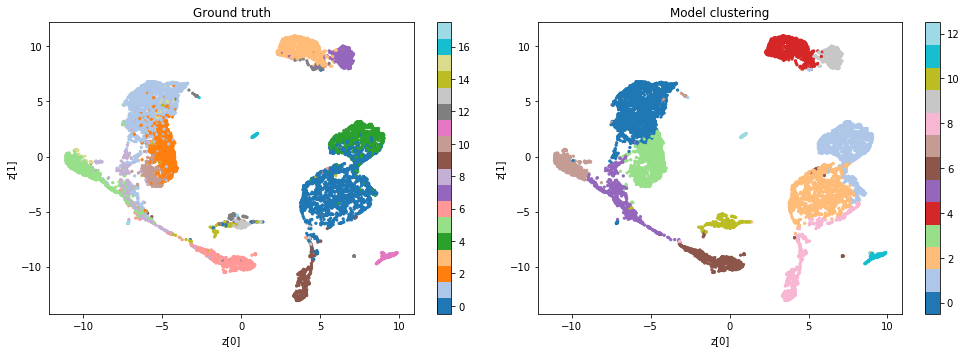

Measures of clusters similarity:

adjusted random index = 0.6382175390878992
adjusted mutual information = 0.7455126841400547
clustering accuracy = 0.7719567177637511


In [19]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [47]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.adata.X)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.685
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES = 0.7
N_NBS = 7
N_PCS = 40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC10k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [36]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [37]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
# Network parameters
# parameters = {
#     'latent_dim': 100,
#     'layers_enc_dim': [1000, 500, 400, 300, 200],
#     'layers_dec_dim': [200, 300, 400, 500, 1000],
#     'batch_size': 1000,
#     'epochs': 5000
# }
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

Total params: 906,165
Trainable params: 904,965
Non-trainable params: 1,200
__________________________________________________________________________________________________


In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC10k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC10k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC10k/graphs/autoencoder.png)

### Train the model

In [11]:
import time
start = time.time()

In [12]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc10k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 8 steps, validate for 2 steps
Epoch 1/500
8/8 [==============================] - 6s 735ms/step - loss: 3217.6324 - val_loss: 3069.5796
Epoch 2/500
8/8 [==============================] - 1s 138ms/step - loss: 3015.7090 - val_loss: 2941.9417
Epoch 3/500
8/8 [==============================] - 1s 145ms/step - loss: 2838.5810 - val_loss: 2855.4491
Epoch 4/500
8/8 [==============================] - 1s 136ms/step - loss: 2709.1179 - val_loss: 2786.0481
Epoch 5/500
8/8 [==============================] - 1s 130ms/step - loss: 2590.7911 - val_loss: 2727.3512
Epoch 6/500
8/8 [==============================] - 1s 128ms/step - loss: 2501.9367 - val_loss: 2675.9681
Epoch 7/500
8/8 [==============================] - 1s 132ms/step - loss: 2433.5291 - val_loss: 2628.9075
Epoch 8/500
8/8 [==============================] - 1s 131ms/step - loss: 2370.1415 - val_loss: 2587.1367
Epoch 9/500
8/8 [==============================] - 1s 133ms/step - loss: 2321.5205 - val_loss: 2

Epoch 78/500
8/8 [==============================] - 1s 126ms/step - loss: 1961.6762 - val_loss: 1994.6214
Epoch 79/500
8/8 [==============================] - 1s 127ms/step - loss: 1967.1633 - val_loss: 1994.4036
Epoch 80/500
8/8 [==============================] - 1s 131ms/step - loss: 1971.0236 - val_loss: 1994.0341
Epoch 81/500
8/8 [==============================] - 1s 124ms/step - loss: 1958.8417 - val_loss: 1993.8795
Epoch 82/500
8/8 [==============================] - 1s 126ms/step - loss: 1964.4604 - val_loss: 1993.6317
Epoch 83/500
8/8 [==============================] - 1s 123ms/step - loss: 1961.4664 - val_loss: 1993.3589
Epoch 84/500
8/8 [==============================] - 1s 129ms/step - loss: 1964.5506 - val_loss: 1993.1066
Epoch 85/500
8/8 [==============================] - 1s 127ms/step - loss: 1943.5088 - val_loss: 1992.8378
Epoch 86/500
8/8 [==============================] - 1s 127ms/step - loss: 1967.0764 - val_loss: 1992.6581
Epoch 87/500
8/8 [============================

Epoch 155/500
8/8 [==============================] - 1s 132ms/step - loss: 1948.2747 - val_loss: 1986.6986
Epoch 156/500
8/8 [==============================] - 1s 139ms/step - loss: 1938.0161 - val_loss: 1986.6573
Epoch 157/500
8/8 [==============================] - 1s 134ms/step - loss: 1939.2557 - val_loss: 1986.5697
Epoch 158/500
8/8 [==============================] - 1s 128ms/step - loss: 1932.0094 - val_loss: 1986.5580
Epoch 159/500
8/8 [==============================] - 1s 133ms/step - loss: 1942.2689 - val_loss: 1986.5443
Epoch 160/500
8/8 [==============================] - 1s 131ms/step - loss: 1946.6126 - val_loss: 1986.4777
Epoch 161/500
8/8 [==============================] - 1s 128ms/step - loss: 1940.2104 - val_loss: 1986.4172
Epoch 162/500
8/8 [==============================] - 1s 126ms/step - loss: 1949.0826 - val_loss: 1986.4464
Epoch 163/500
8/8 [==============================] - 1s 128ms/step - loss: 1934.6879 - val_loss: 1986.3513
Epoch 164/500
8/8 [==================

8/8 [==============================] - 1s 146ms/step - loss: 1929.0558 - val_loss: 1985.0752
Epoch 232/500
8/8 [==============================] - 1s 138ms/step - loss: 1948.4087 - val_loss: 1985.0568
Epoch 233/500
8/8 [==============================] - 1s 136ms/step - loss: 1941.0405 - val_loss: 1985.0225
Epoch 234/500
8/8 [==============================] - 1s 139ms/step - loss: 1935.0310 - val_loss: 1984.9719
Epoch 235/500
8/8 [==============================] - 1s 142ms/step - loss: 1934.1825 - val_loss: 1984.9965
Epoch 236/500
8/8 [==============================] - 1s 137ms/step - loss: 1945.8148 - val_loss: 1984.9518
Epoch 237/500
8/8 [==============================] - 1s 137ms/step - loss: 1934.5602 - val_loss: 1984.9211
Epoch 238/500
8/8 [==============================] - 1s 139ms/step - loss: 1928.9551 - val_loss: 1984.9331
Epoch 239/500
8/8 [==============================] - 1s 140ms/step - loss: 1928.1972 - val_loss: 1984.9238
Epoch 240/500
8/8 [==============================] 

8/8 [==============================] - 1s 143ms/step - loss: 1939.7077 - val_loss: 1984.4341
Epoch 308/500
8/8 [==============================] - 1s 142ms/step - loss: 1941.0790 - val_loss: 1984.4495
Epoch 309/500
8/8 [==============================] - 1s 142ms/step - loss: 1919.7771 - val_loss: 1984.4147
Epoch 310/500
8/8 [==============================] - 1s 142ms/step - loss: 1932.5248 - val_loss: 1984.3868
Epoch 311/500
8/8 [==============================] - 1s 138ms/step - loss: 1922.6006 - val_loss: 1984.4219
Epoch 312/500
8/8 [==============================] - 1s 143ms/step - loss: 1939.1999 - val_loss: 1984.3943
Epoch 313/500
8/8 [==============================] - 1s 138ms/step - loss: 1935.3381 - val_loss: 1984.4037
Epoch 314/500
8/8 [==============================] - 1s 138ms/step - loss: 1937.4922 - val_loss: 1984.4029
Epoch 315/500
8/8 [==============================] - 1s 160ms/step - loss: 1938.9106 - val_loss: 1984.3536
Epoch 316/500
8/8 [==============================] 

8/8 [==============================] - 1s 140ms/step - loss: 1932.4996 - val_loss: 1984.1559
Epoch 384/500
8/8 [==============================] - 1s 138ms/step - loss: 1938.4458 - val_loss: 1984.1356
Epoch 385/500
8/8 [==============================] - 1s 140ms/step - loss: 1934.1212 - val_loss: 1984.1719
Epoch 386/500
8/8 [==============================] - 1s 150ms/step - loss: 1941.3160 - val_loss: 1984.1476
Epoch 387/500
8/8 [==============================] - 1s 146ms/step - loss: 1935.7259 - val_loss: 1984.1298
Epoch 388/500
8/8 [==============================] - 1s 143ms/step - loss: 1933.9328 - val_loss: 1984.1522
Epoch 389/500
8/8 [==============================] - 1s 145ms/step - loss: 1939.5053 - val_loss: 1984.1136
Epoch 390/500
8/8 [==============================] - 1s 143ms/step - loss: 1916.3303 - val_loss: 1984.1329
Epoch 391/500
8/8 [==============================] - 1s 140ms/step - loss: 1937.0325 - val_loss: 1984.1191
Epoch 392/500
8/8 [==============================] 

8/8 [==============================] - 1s 169ms/step - loss: 1936.9983 - val_loss: 1984.0198
Epoch 460/500
8/8 [==============================] - 1s 158ms/step - loss: 1930.8295 - val_loss: 1983.9874
Epoch 461/500
8/8 [==============================] - 1s 157ms/step - loss: 1932.9516 - val_loss: 1984.0014
Epoch 462/500
8/8 [==============================] - 1s 148ms/step - loss: 1934.1284 - val_loss: 1983.9818
Epoch 463/500
8/8 [==============================] - 1s 144ms/step - loss: 1921.1688 - val_loss: 1983.9902
Epoch 464/500
8/8 [==============================] - 1s 142ms/step - loss: 1926.9840 - val_loss: 1984.0011
Epoch 465/500
8/8 [==============================] - 1s 144ms/step - loss: 1937.5022 - val_loss: 1983.9854
Epoch 466/500
8/8 [==============================] - 1s 144ms/step - loss: 1938.4930 - val_loss: 1984.0059
Epoch 467/500
8/8 [==============================] - 1s 145ms/step - loss: 1939.0976 - val_loss: 1984.0051
Epoch 468/500
8/8 [==============================] 

In [13]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:09:26.67


In [ ]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
gene_list = ['CST3']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/VAE/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [17]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [43:36<00:00, 14.87s/it]


In [18]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

55
127
127


In [19]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.8 16


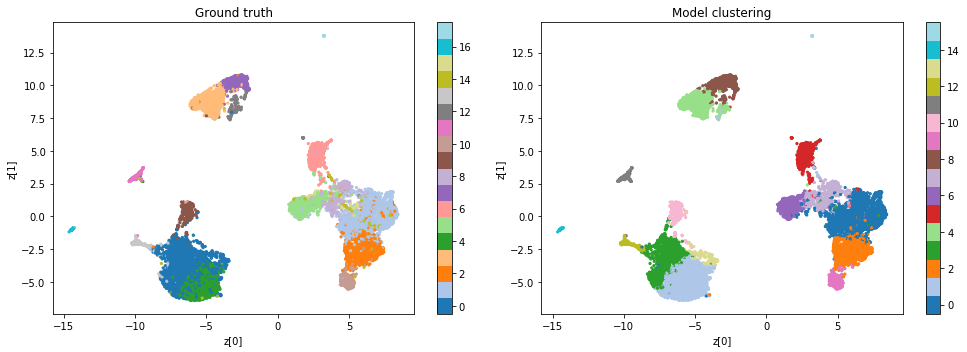

Measures of clusters similarity:

adjusted random index = 0.6583853132655431
adjusted mutual information = 0.7842456318302405
clustering accuracy = 0.7972046889089269


In [20]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

# Clustering analysis on 8k PBMC data¶

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 1000,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1330)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          266200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC8k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC8k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC8k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC8k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC8k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC8k/graphs/autoencoder.png)

### Train the model

In [12]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc8k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 20/20, rec. loss: 0.908094, dis. loss: 0.224129


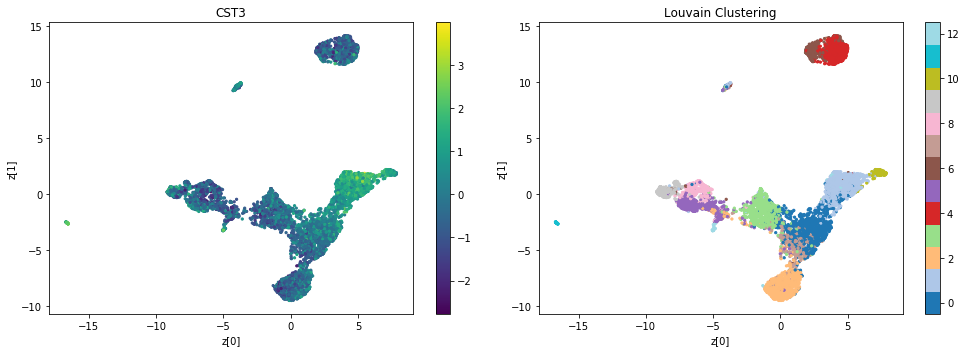

Training completed.
All networks exported in h5 format.


In [13]:
# Training...

log_dir = '../results/AAE1/PBMC8k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC8k/

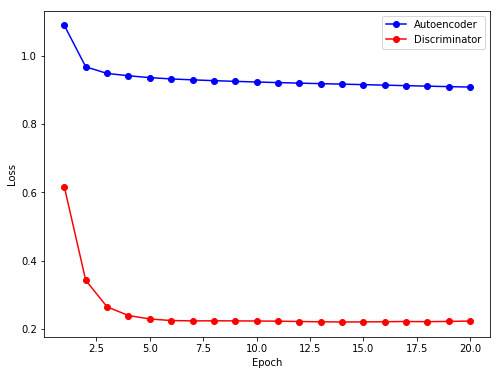

In [14]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

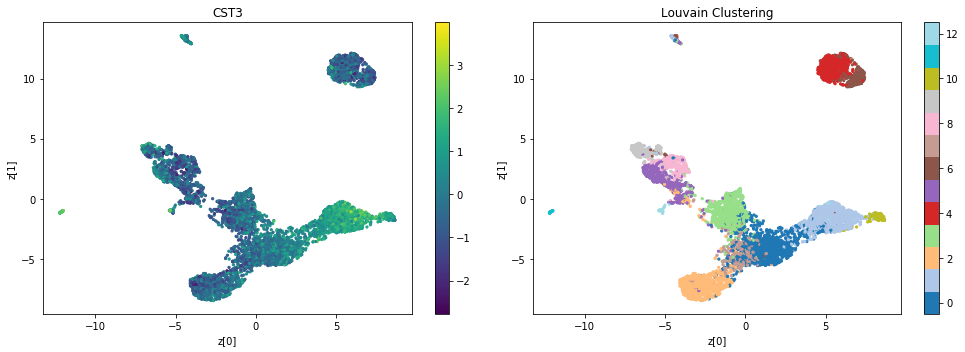

In [15]:
GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [16]:
from tensorflow.keras.models import load_model

log_dir = '../results/AAE1/PBMC8k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [17]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [50:12<00:00, 17.12s/it]


In [18]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

84
119
106


In [19]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.85 14


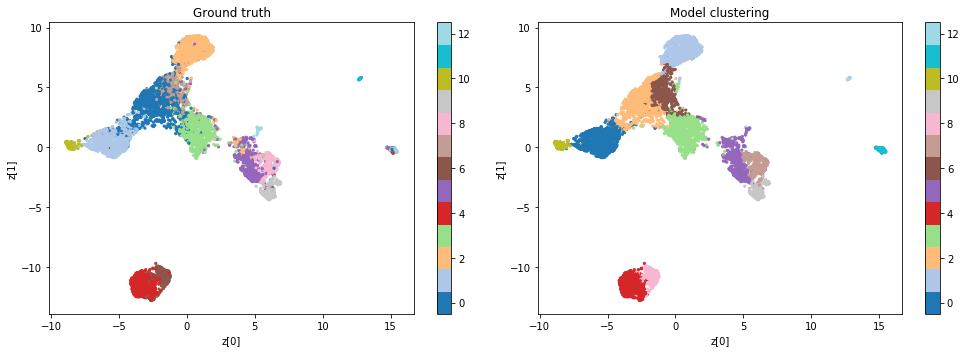

Measures of clusters similarity:

adjusted random index = 0.7250001098051719
adjusted mutual information = 0.7619221030032381
clustering accuracy = 0.8421404682274247


In [20]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC8k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC8k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC8k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC8k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC8k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC8k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc8k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC8k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC8k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [36]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [37]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 1000,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False
# TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1330)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          266200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC8k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC8k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC8k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC8k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC8k/graphs/autoencoder.png)

### Train the model

In [12]:
# Training...

log_dir = '../results/VAE/PBMC8k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc8k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'Dataset',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 5 steps, validate for 1 steps
Epoch 1/500
5/5 [==============================] - 6s 1s/step - loss: 1674.3296 - val_loss: 1674.1995
Epoch 2/500
5/5 [==============================] - 0s 89ms/step - loss: 1645.3498 - val_loss: 1662.8770
Epoch 3/500
5/5 [==============================] - 0s 95ms/step - loss: 1624.7534 - val_loss: 1654.3693
Epoch 4/500
5/5 [==============================] - 0s 100ms/step - loss: 1595.5724 - val_loss: 1646.8469
Epoch 5/500
5/5 [==============================] - 1s 110ms/step - loss: 1578.3660 - val_loss: 1639.6288
Epoch 6/500
5/5 [==============================] - 1s 117ms/step - loss: 1565.2128 - val_loss: 1632.1558
Epoch 7/500
5/5 [==============================] - 0s 92ms/step - loss: 1545.1048 - val_loss: 1625.2648
Epoch 8/500
5/5 [==============================] - 0s 98ms/step - loss: 1521.0777 - val_loss: 1617.5618
Epoch 9/500
5/5 [==============================] - 1s 104ms/step - loss: 1518.6210 - val_loss: 1611.420

5/5 [==============================] - 1s 107ms/step - loss: 1269.5830 - val_loss: 1286.3195
Epoch 79/500
5/5 [==============================] - 1s 107ms/step - loss: 1273.4762 - val_loss: 1286.0793
Epoch 80/500
5/5 [==============================] - 1s 112ms/step - loss: 1260.5580 - val_loss: 1285.6110
Epoch 81/500
5/5 [==============================] - 1s 104ms/step - loss: 1265.7879 - val_loss: 1284.8325
Epoch 82/500
5/5 [==============================] - 1s 101ms/step - loss: 1256.7588 - val_loss: 1284.4260
Epoch 83/500
5/5 [==============================] - 1s 107ms/step - loss: 1262.8683 - val_loss: 1283.9242
Epoch 84/500
5/5 [==============================] - 0s 94ms/step - loss: 1267.7966 - val_loss: 1283.2467
Epoch 85/500
5/5 [==============================] - 1s 101ms/step - loss: 1267.8116 - val_loss: 1283.4845
Epoch 86/500
5/5 [==============================] - 0s 95ms/step - loss: 1258.4593 - val_loss: 1282.5254
Epoch 87/500
5/5 [==============================] - 0s 99ms/s

5/5 [==============================] - 0s 92ms/step - loss: 1244.2417 - val_loss: 1266.4117
Epoch 156/500
5/5 [==============================] - 0s 93ms/step - loss: 1247.5306 - val_loss: 1266.3268
Epoch 157/500
5/5 [==============================] - 0s 91ms/step - loss: 1246.9302 - val_loss: 1265.8342
Epoch 158/500
5/5 [==============================] - 0s 88ms/step - loss: 1246.8682 - val_loss: 1265.9232
Epoch 159/500
5/5 [==============================] - 0s 87ms/step - loss: 1245.8040 - val_loss: 1265.4927
Epoch 160/500
5/5 [==============================] - 0s 90ms/step - loss: 1251.5942 - val_loss: 1265.3867
Epoch 161/500
5/5 [==============================] - 0s 94ms/step - loss: 1244.1887 - val_loss: 1265.3589
Epoch 162/500
5/5 [==============================] - 1s 103ms/step - loss: 1236.8983 - val_loss: 1264.9757
Epoch 163/500
5/5 [==============================] - 0s 90ms/step - loss: 1253.7192 - val_loss: 1264.9097
Epoch 164/500
5/5 [==============================] - 1s 106

5/5 [==============================] - 0s 85ms/step - loss: 1235.5205 - val_loss: 1257.4385
Epoch 233/500
5/5 [==============================] - 0s 89ms/step - loss: 1240.6718 - val_loss: 1257.3495
Epoch 234/500
5/5 [==============================] - 0s 93ms/step - loss: 1234.5128 - val_loss: 1257.6897
Epoch 235/500
5/5 [==============================] - 0s 90ms/step - loss: 1230.0394 - val_loss: 1257.4507
Epoch 236/500
5/5 [==============================] - 0s 91ms/step - loss: 1250.6163 - val_loss: 1257.5811
Epoch 237/500
5/5 [==============================] - 0s 94ms/step - loss: 1228.1447 - val_loss: 1257.0952
Epoch 238/500
5/5 [==============================] - 0s 91ms/step - loss: 1240.4707 - val_loss: 1257.3407
Epoch 239/500
5/5 [==============================] - 0s 89ms/step - loss: 1235.6954 - val_loss: 1257.0918
Epoch 240/500
5/5 [==============================] - 0s 91ms/step - loss: 1236.8255 - val_loss: 1256.8153
Epoch 241/500
5/5 [==============================] - 0s 88ms

5/5 [==============================] - 0s 80ms/step - loss: 1233.3425 - val_loss: 1253.2395
Epoch 310/500
5/5 [==============================] - 0s 76ms/step - loss: 1228.3050 - val_loss: 1253.0631
Epoch 311/500
5/5 [==============================] - 0s 86ms/step - loss: 1238.6953 - val_loss: 1252.8995
Epoch 312/500
5/5 [==============================] - 0s 92ms/step - loss: 1232.5168 - val_loss: 1253.1992
Epoch 313/500
5/5 [==============================] - 0s 82ms/step - loss: 1226.9290 - val_loss: 1253.0002
Epoch 314/500
5/5 [==============================] - 0s 82ms/step - loss: 1229.4337 - val_loss: 1252.9257
Epoch 315/500
5/5 [==============================] - 0s 76ms/step - loss: 1232.0212 - val_loss: 1252.7023
Epoch 316/500
5/5 [==============================] - 0s 80ms/step - loss: 1249.1397 - val_loss: 1252.6818
Epoch 317/500
5/5 [==============================] - 0s 76ms/step - loss: 1222.1812 - val_loss: 1252.8328
Epoch 318/500
5/5 [==============================] - 0s 74ms

5/5 [==============================] - 0s 99ms/step - loss: 1227.2327 - val_loss: 1249.8820
Epoch 387/500
5/5 [==============================] - 0s 97ms/step - loss: 1227.9724 - val_loss: 1249.7753
Epoch 388/500
5/5 [==============================] - 0s 87ms/step - loss: 1231.1976 - val_loss: 1249.6975
Epoch 389/500
5/5 [==============================] - 0s 88ms/step - loss: 1211.5226 - val_loss: 1249.8607
Epoch 390/500
5/5 [==============================] - 0s 89ms/step - loss: 1237.1451 - val_loss: 1249.7501
Epoch 391/500
5/5 [==============================] - 0s 90ms/step - loss: 1227.5345 - val_loss: 1249.7002
Epoch 392/500
5/5 [==============================] - 0s 89ms/step - loss: 1214.3141 - val_loss: 1249.4518
Epoch 393/500
5/5 [==============================] - 0s 85ms/step - loss: 1230.1034 - val_loss: 1249.1692
Epoch 394/500
5/5 [==============================] - 0s 86ms/step - loss: 1235.8958 - val_loss: 1249.3895
Epoch 395/500
5/5 [==============================] - 0s 88ms

5/5 [==============================] - 0s 90ms/step - loss: 1223.5965 - val_loss: 1246.8021
Epoch 464/500
5/5 [==============================] - 0s 88ms/step - loss: 1220.9969 - val_loss: 1246.7034
Epoch 465/500
5/5 [==============================] - 0s 88ms/step - loss: 1221.4757 - val_loss: 1246.8378
Epoch 466/500
5/5 [==============================] - 0s 88ms/step - loss: 1233.0363 - val_loss: 1246.6512
Epoch 467/500
5/5 [==============================] - 0s 87ms/step - loss: 1218.6490 - val_loss: 1246.7209
Epoch 468/500
5/5 [==============================] - 0s 88ms/step - loss: 1225.1965 - val_loss: 1246.6632
Epoch 469/500
5/5 [==============================] - 0s 89ms/step - loss: 1208.6772 - val_loss: 1246.6040
Epoch 470/500
5/5 [==============================] - 0s 87ms/step - loss: 1231.3637 - val_loss: 1246.6233
Epoch 471/500
5/5 [==============================] - 0s 89ms/step - loss: 1225.5052 - val_loss: 1246.7592
Epoch 472/500
5/5 [==============================] - 0s 88ms

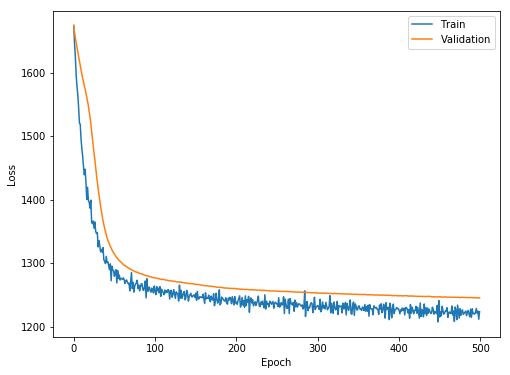

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

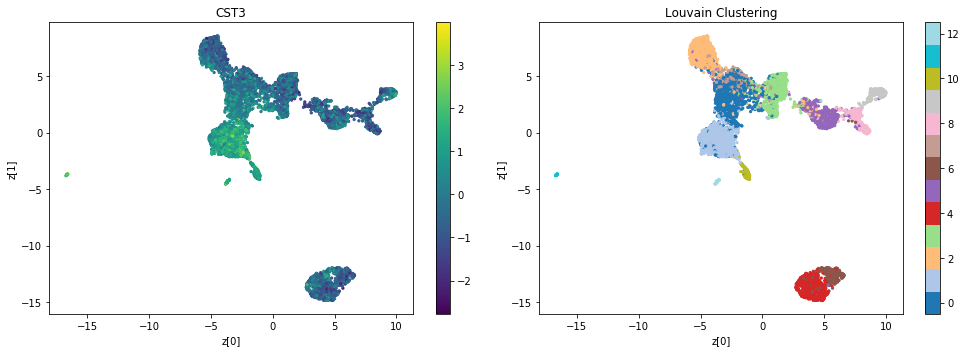

In [14]:
gene_list = ['CST3']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/VAE/PBMC8k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [16]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [1:02:03<00:00, 21.16s/it]


In [17]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

93
125
93


In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.75 13


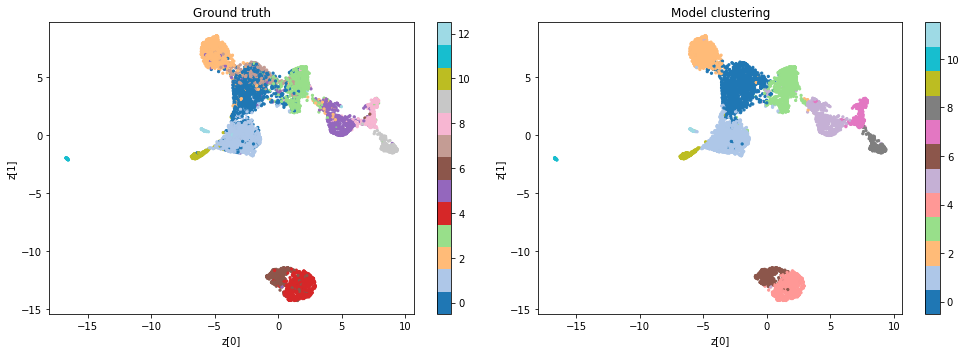

Measures of clusters similarity:

adjusted random index = 0.7222648996494563
adjusted mutual information = 0.7697887654525835
clustering accuracy = 0.8535117056856187


In [19]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [20]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [21]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

# Clustering analysis on 3k PBMC data

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'layers_dis_dim': [200, 100, 50, 40, 30],
    'batch_size': 300,
    'epochs': 20
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,300,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1838)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          367800      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC3k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC3k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC3k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC3k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC3k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC3k/graphs/autoencoder.png)

### Train the model

In [11]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc3k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 20/20, rec. loss: 0.951270, dis. loss: 0.227757


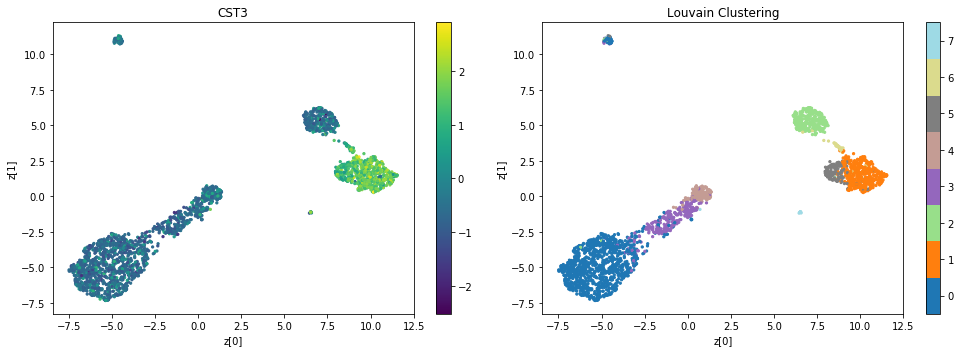

Training completed.
All networks exported in h5 format.


In [12]:
# Training...

log_dir = '../results/AAE1/PBMC3k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC3k/

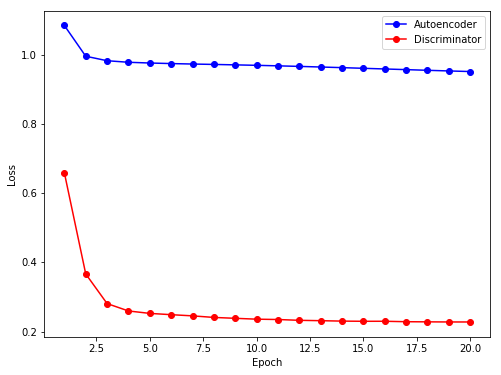

In [13]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

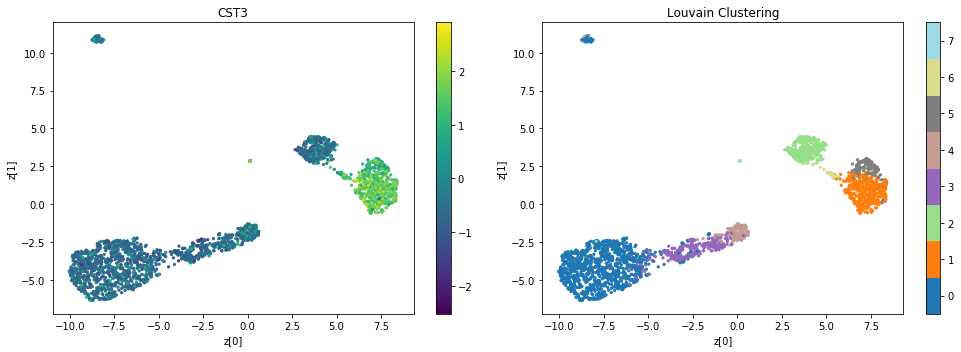

In [14]:
GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
from tensorflow.keras.models import load_model

log_dir = '../results/AAE1/PBMC3k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [16]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [15:32<00:00,  5.30s/it]


In [17]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

111
111
99


In [18]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 14


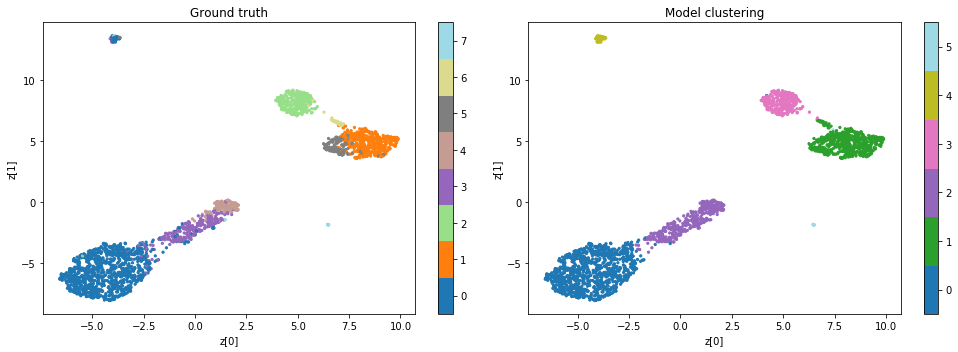

Measures of clusters similarity:

adjusted random index = 0.789900085120574
adjusted mutual information = 0.7269260766131123
clustering accuracy = 0.819560272934041


In [19]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [21]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [22]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

else:
     model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC3k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC3k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC3k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC3k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC3k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC3k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc3k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC3k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC3k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

In [ ]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

In [ ]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

In [ ]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [36]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [37]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200, 100],
    'layers_dec_dim': [100, 200],
    'batch_size': 300,
    'epochs': 500
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,300,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False
# TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 1838)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          367800      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC3k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC3k/graphs')

Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC3k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC3k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC3k/graphs/autoencoder.png)

### Train the model

In [14]:
# Training...

log_dir = '../results/VAE/PBMC3k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc3k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'Dataset',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 7 steps, validate for 1 steps
Epoch 1/500
7/7 [==============================] - 4s 529ms/step - loss: 2308.9975 - val_loss: 2242.5149
Epoch 2/500
7/7 [==============================] - 0s 38ms/step - loss: 2265.7782 - val_loss: 2226.8501
Epoch 3/500
7/7 [==============================] - 0s 37ms/step - loss: 2224.8841 - val_loss: 2212.7676
Epoch 4/500
7/7 [==============================] - 0s 39ms/step - loss: 2187.4627 - val_loss: 2199.5107
Epoch 5/500
7/7 [==============================] - 0s 38ms/step - loss: 2152.2404 - val_loss: 2187.3923
Epoch 6/500
7/7 [==============================] - 0s 38ms/step - loss: 2127.5723 - val_loss: 2176.5547
Epoch 7/500
7/7 [==============================] - 0s 39ms/step - loss: 2088.4386 - val_loss: 2163.8792
Epoch 8/500
7/7 [==============================] - 0s 40ms/step - loss: 2069.3062 - val_loss: 2155.7656
Epoch 9/500
7/7 [==============================] - 0s 41ms/step - loss: 2051.9545 - val_loss: 2141.6116

7/7 [==============================] - 0s 31ms/step - loss: 1823.7968 - val_loss: 1763.5522
Epoch 79/500
7/7 [==============================] - 0s 30ms/step - loss: 1802.7871 - val_loss: 1763.5911
Epoch 80/500
7/7 [==============================] - 0s 30ms/step - loss: 1806.2033 - val_loss: 1763.0519
Epoch 81/500
7/7 [==============================] - 0s 30ms/step - loss: 1813.8536 - val_loss: 1763.1516
Epoch 82/500
7/7 [==============================] - 0s 30ms/step - loss: 1852.6775 - val_loss: 1762.4485
Epoch 83/500
7/7 [==============================] - 0s 30ms/step - loss: 1807.1634 - val_loss: 1762.7765
Epoch 84/500
7/7 [==============================] - 0s 31ms/step - loss: 1800.6787 - val_loss: 1762.5675
Epoch 85/500
7/7 [==============================] - 0s 30ms/step - loss: 1816.5218 - val_loss: 1762.1481
Epoch 86/500
7/7 [==============================] - 0s 34ms/step - loss: 1812.9127 - val_loss: 1761.9900
Epoch 87/500
7/7 [==============================] - 0s 30ms/step - l

7/7 [==============================] - 0s 40ms/step - loss: 1796.0711 - val_loss: 1754.1179
Epoch 156/500
7/7 [==============================] - 0s 39ms/step - loss: 1808.2163 - val_loss: 1754.1533
Epoch 157/500
7/7 [==============================] - 0s 37ms/step - loss: 1806.6092 - val_loss: 1753.7305
Epoch 158/500
7/7 [==============================] - 0s 38ms/step - loss: 1800.4112 - val_loss: 1753.3300
Epoch 159/500
7/7 [==============================] - 0s 40ms/step - loss: 1811.2418 - val_loss: 1753.5975
Epoch 160/500
7/7 [==============================] - 0s 37ms/step - loss: 1798.0574 - val_loss: 1753.6304
Epoch 161/500
7/7 [==============================] - 0s 37ms/step - loss: 1806.0078 - val_loss: 1753.9156
Epoch 162/500
7/7 [==============================] - 0s 41ms/step - loss: 1795.6823 - val_loss: 1752.9873
Epoch 163/500
7/7 [==============================] - 0s 42ms/step - loss: 1809.2327 - val_loss: 1753.5820
Epoch 164/500
7/7 [==============================] - 0s 39ms

7/7 [==============================] - 0s 32ms/step - loss: 1798.2956 - val_loss: 1751.3406
Epoch 233/500
7/7 [==============================] - 0s 32ms/step - loss: 1794.6965 - val_loss: 1751.7494
Epoch 234/500
7/7 [==============================] - 0s 33ms/step - loss: 1797.4153 - val_loss: 1751.4558
Epoch 235/500
7/7 [==============================] - 0s 33ms/step - loss: 1789.8489 - val_loss: 1750.9821
Epoch 236/500
7/7 [==============================] - 0s 33ms/step - loss: 1809.1070 - val_loss: 1750.8102
Epoch 237/500
7/7 [==============================] - 0s 32ms/step - loss: 1783.6308 - val_loss: 1750.9319
Epoch 238/500
7/7 [==============================] - 0s 33ms/step - loss: 1810.9357 - val_loss: 1751.2167
Epoch 239/500
7/7 [==============================] - 0s 32ms/step - loss: 1793.3821 - val_loss: 1751.2733
Epoch 240/500
7/7 [==============================] - 0s 33ms/step - loss: 1796.4844 - val_loss: 1751.1333
Epoch 241/500
7/7 [==============================] - 0s 32ms

7/7 [==============================] - 0s 38ms/step - loss: 1779.2812 - val_loss: 1749.6594
Epoch 310/500
7/7 [==============================] - 0s 42ms/step - loss: 1783.6249 - val_loss: 1749.7509
Epoch 311/500
7/7 [==============================] - 0s 36ms/step - loss: 1805.2125 - val_loss: 1749.8413
Epoch 312/500
7/7 [==============================] - 0s 34ms/step - loss: 1791.8986 - val_loss: 1750.5446
Epoch 313/500
7/7 [==============================] - 0s 35ms/step - loss: 1789.5295 - val_loss: 1749.5973
Epoch 314/500
7/7 [==============================] - 0s 34ms/step - loss: 1788.6636 - val_loss: 1750.0906
Epoch 315/500
7/7 [==============================] - 0s 40ms/step - loss: 1786.9043 - val_loss: 1749.8873
Epoch 316/500
7/7 [==============================] - 0s 48ms/step - loss: 1788.0360 - val_loss: 1750.1132
Epoch 317/500
7/7 [==============================] - 0s 51ms/step - loss: 1797.9193 - val_loss: 1750.2656
Epoch 318/500
7/7 [==============================] - 0s 47ms

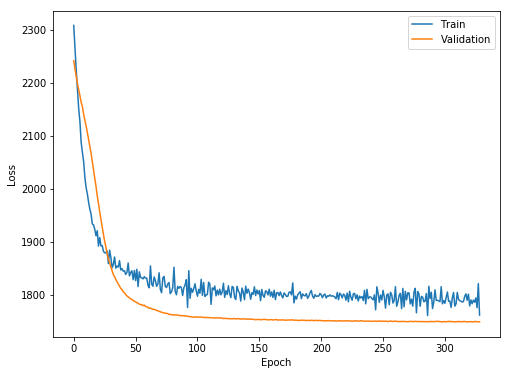

In [16]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

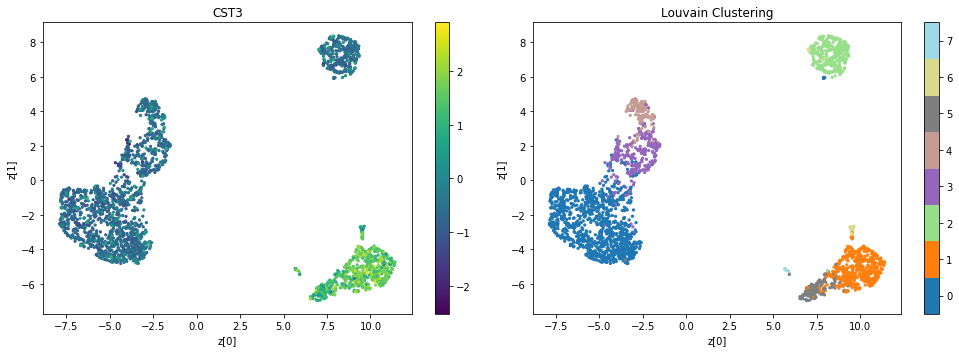

In [17]:
gene_list = ['CST3']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/VAE/PBMC3k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [19]:
res = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
n_nbs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
n_pcs = [40]

out = cluster_grid_scan(model, labels_true, res, n_nbs, n_pcs)

100%|██████████| 176/176 [1:19:04<00:00, 26.95s/it]    


In [21]:
print(out['ARI'].argmax())
print(out['AMI'].argmax())
print(out['CA'].argmax())

88
88
88


In [22]:
k = out['CA'].argmax()
print(out['res'][k], out['n_nbs'][k])

0.5 13


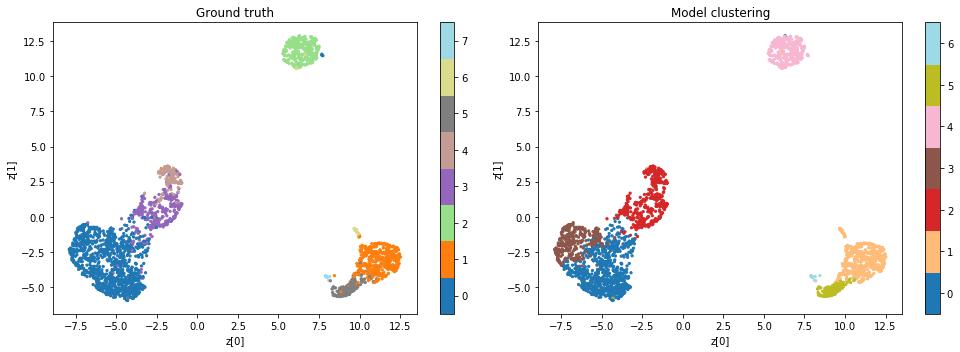

Measures of clusters similarity:

adjusted random index = 0.6484667539992132
adjusted mutual information = 0.742921251146144
clustering accuracy = 0.7524639878695982


In [23]:
k = out['CA'].argmax()

RES = out['res'][k]
N_NBS = out['n_nbs'][k]
N_PCS = out['n_pcs'][k]

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

Z, ARI, AMI, CA = model.eval_clustering(labels_true, labels_pred, graph=True)

In [24]:
# Z
np.savetxt(log_dir + 'examples/run1/' + 'z_umap.txt', Z)

In [25]:
np.savetxt(log_dir + 'examples/run1/' + 'labels_true.txt', np.array(labels_true), fmt='%d')
np.savetxt(log_dir + 'examples/run1/' + 'labels_pred.txt', np.array(labels_pred), fmt='%d')

In [32]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


In [ ]:
RES = 0.55
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

In [ ]:
RES=0.8
N_NBS=15
N_PCS=40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)